<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/gpt-neo/661_GPT_Neo_Hate_Speech_ZSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-Neo Hate Speech
This notebook will prompt a pretrained GPT-Neo on the Hate Speech dataset via Zero Shot Prompting.

## Setup

In [1]:
!pip install datasets transformers torch scikit-learn matplotlib seaborn

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Dataset and Model

In [2]:
!git clone https://github.com/Vicomtech/hate-speech-dataset.git

df = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

df = df.loc[df['label'] != 'relation']
df = df.loc[df['label'] != 'idk/skip']

label_mapping = {
    "noHate": 0,
    "hate": 1
}

df['label'] = df['label'].map(label_mapping)

train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label'], random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Cloning into 'hate-speech-dataset'...
remote: Enumerating objects: 10785, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10785 (delta 6), reused 0 (delta 0), pack-reused 10771 (from 1)
Receiving objects: 100% (10785/10785), 1.16 MiB | 3.56 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
model_name = "EleutherAI/gpt-neo-2.7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

## Evaluation

In [4]:
def classify_text(review):
    prompt = f"Determine if the text expresses hate or noHate: '{review}'\nCategory:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=128).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            early_stopping=True,
            num_beams=1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.1
        )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True).split('Category:')[-1].strip()
    if prediction.lower() == "nohate":
        return 0
    elif prediction.lower() == "hate":
        return 1
    else:
        return None

true_labels = []
predicted_labels = []

for i, row in val_df.iterrows():
    file_id = row['file_id']
    true_label = row['label']
    true_labels.append(true_label)

    with open(f'hate-speech-dataset/all_files/{file_id}.txt', 'r') as file:
        text = file.read()

        predicted_label = classify_text(text)
        predicted_labels.append(predicted_label)

    if i % 100 == 0:
        print(f"Processed {i}/{len(val_df)} samples...")


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Processed 0/1070 samples...
Processed 100/1070 samples...
Processed 200/1070 samples...
Processed 300/1070 samples...
Processed 400/1070 samples...
Processed 500/1070 samples...
Processed 600/1070 samples...
Processed 700/1070 samples...
Processed 800/1070 samples...
Processed 900/1070 samples...
Processed 1000/1070 samples...


## Graphs and Table

Zero-shot accuracy on the validation set: 88.79%
Classification Report:
              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       951
        hate       0.00      0.00      0.00       119

    accuracy                           0.89      1070
   macro avg       0.44      0.50      0.47      1070
weighted avg       0.79      0.89      0.84      1070



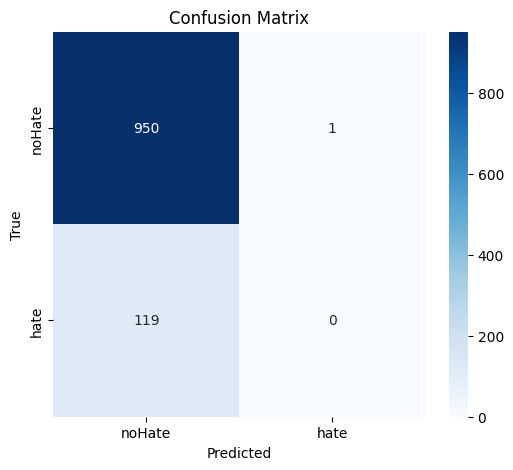

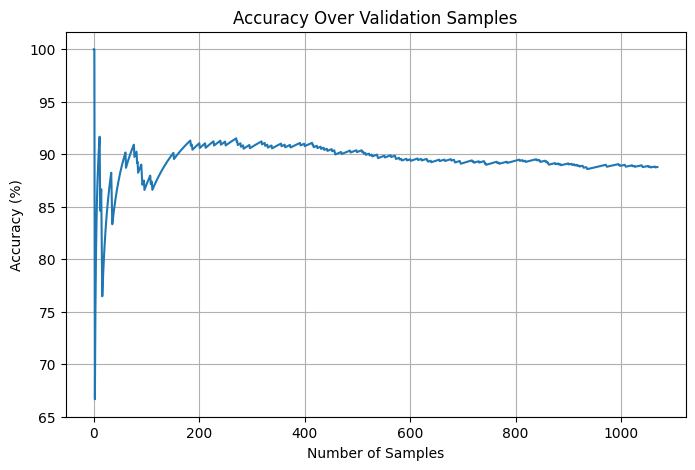

In [5]:
predicted_labels = [p if p is not None else 0 for p in predicted_labels]

# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Zero-shot accuracy on the validation set: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["noHate", "hate"]))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["noHate", "hate"], yticklabels=["noHate", "hate"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()


# GPT-Neo Hate Speech ChatGPT Prompt
This portion of the notebook will prompt a pretrained GPT-Neo on the Hate Speech dataset using prompt generated by ChatGPT.

In [6]:
def classify_text(review):
    prompt = f"Classify the sentiment of this review as either hate or noHate: '{review}'\nCategory:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=128).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            early_stopping=True,
            num_beams=1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.1
        )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True).split('Category:')[-1].strip()
    if prediction.lower() == "nohate":
        return 0
    elif prediction.lower() == "hate":
        return 1
    else:
        return None

true_labels = []
predicted_labels = []

for i, row in val_df.iterrows():
    file_id = row['file_id']
    true_label = row['label']
    true_labels.append(true_label)

    with open(f'hate-speech-dataset/all_files/{file_id}.txt', 'r') as file:
        text = file.read()

        predicted_label = classify_text(text)
        predicted_labels.append(predicted_label)

    if i % 100 == 0:
        print(f"Processed {i}/{len(val_df)} samples...")


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Processed 0/1070 samples...
Processed 100/1070 samples...
Processed 200/1070 samples...
Processed 300/1070 samples...
Processed 400/1070 samples...
Processed 500/1070 samples...
Processed 600/1070 samples...
Processed 700/1070 samples...
Processed 800/1070 samples...
Processed 900/1070 samples...
Processed 1000/1070 samples...


Zero-shot accuracy on the validation set: 88.88%
Classification Report:
              precision    recall  f1-score   support

      noHate       0.89      1.00      0.94       951
        hate       0.00      0.00      0.00       119

    accuracy                           0.89      1070
   macro avg       0.44      0.50      0.47      1070
weighted avg       0.79      0.89      0.84      1070



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


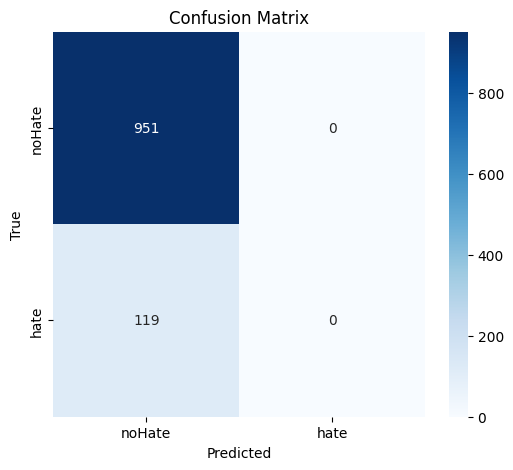

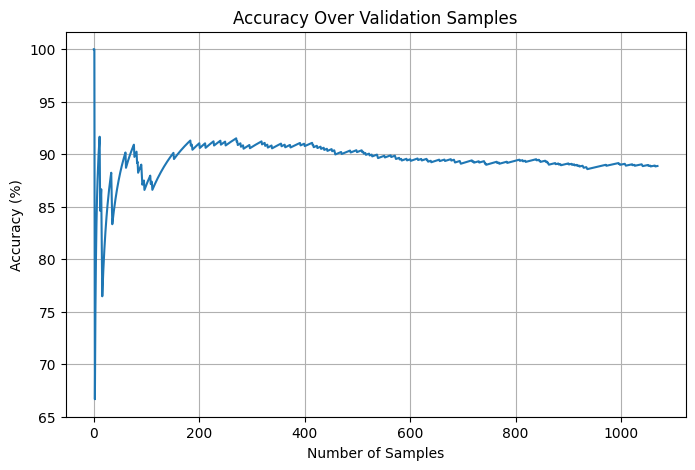

In [7]:
predicted_labels = [p if p is not None else 0 for p in predicted_labels]

# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Zero-shot accuracy on the validation set: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["noHate", "hate"]))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["noHate", "hate"], yticklabels=["noHate", "hate"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()
